# DONHa classifier <br>
Application nstructions <br> <br>

This notebook contains all the essential functions and processes for importing your galaxy dataset (.csv or .fits) for classification. It is organized into three sections:

- **Section 0**: Imports the necessary Python packages and defines the functions required for classification.
- **Section 1**: Implements the DOHNa classifier on the imported galaxy data.
- **Section 2**: Calculates the percentage composition of the sample for each activity class as determined by the DOHNa classifier and plots a histogram for visualization (this section is optional).

Please note that only the first, second, and last cells of Section 2 require user modification to specify the local path to the relevant files.

---

## 0 - Import packages and define functions

In [1]:
import os 
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
import math

In [2]:
def load_file(name, file_format):
    """
    Load a file based on the given format.

    Parameters:
        name (str): The base name of the file (without extension).
        file_format (str): The format of the file, either 'csv' or 'fits'.

    Returns:
        pandas.DataFrame
    """
    if file_format=='csv':
        df = pd.read_csv(name+'.csv')
    elif file_format=='fits':
        dat = Table.read(name+'.fits', format='fits')
        df = dat.to_pandas()
    return df

In [3]:
def RF_classification(clf, dfc):
    """
    Classify/decompose the ativity of galaxies based on their features using a trained Random Forest classifier.

    This function takes a pre-trained Random Forest classifier and a DataFrame of features, predicting the probabilities 
    for each object belonging to 7 different classes; (0: 'Pure SB', 1: 'Pure AGN', 2: 'Pure Pas', 3: 'SB-AGN', 4: 'AGN-SB',
    5: 'SB-pas', 6: 'Pas-SB', 7: 'Pas-AGN', 8: 'AGN-pas', -1: 'Unclassified', see the paper for more details). 
    It then classifies the objects into specific classes or hybrid classes based on their predicted probabilities 
    and defined thresholds.

    Parameters:
        clf (RandomForestClassifier): A pre-trained Random Forest classifier used for predicting the class probabilities.
        dfc (pandas.DataFrame): A DataFrame containing the feature data of the objects to be classified.

    Returns:
        pandas.DataFrame: A DataFrame with the original features, predicted probabilities for each class, 
        and the final classification (column: classification) indicating the category of each object.
    """
    dfc.reset_index(inplace=True, drop=True)
    df_pr = pd.DataFrame(clf.predict_proba(dfc), columns=['proba_RF_SFG', 'proba_RF_AGN', 'proba_RF_PAS'])
    dfp = pd.concat([dfc, df_pr], axis=1)
    dfp['RF_label'] = clf.predict(dfc)
    dfp['mx_prb_mns_sc'] = None
    dfp['mx_prb'] = None
    dfp['scmx_prb_mns_lst'] = None
    dfp['scmx_prb'] = None
    dfp['classification'] = None
    
    for i in range(0, len(df_pr)):
        l = df_pr.iloc[i].tolist()
        nw_ls = [x for x in l if not math.isnan(x)]
        l = nw_ls
        l.sort()
        dfp.loc[i, 'mx_prb_mns_sc'] = l[-1] - l[-2]
        dfp.loc[i, 'mx_prb'] = max(l)
        dfp.loc[i, 'scmx_prb_mns_lst'] = l[1] - l[0]
        dfp.loc[i, 'scmx_prb'] = l[1]
    
    dft = df_pr.T
    for i in range(0, len(df_pr)):
        fst_cls = dft[i].index[np.where((dft[i] == np.max(dft[i])))].tolist()[0]
        snd_cls = dft[i].index[np.where((dft[i] == np.median(dft[i])))].tolist()[0]
        RF_LBL = dfp['RF_label'].iloc[i]
        
        thres = 0.90  # selection threshold (can be modified, see the paper)
        
        if dfp['mx_prb_mns_sc'].iloc[i] < -2 * dfp['scmx_prb_mns_lst'].iloc[i] + 0.8:  # delta_p = -2 * dp' + 0.8
            dfp.loc[i, 'classification'] = -1
        elif dfp['mx_prb'].iloc[i] >= thres and fst_cls == 'proba_RF_SFG':
            dfp.loc[i, 'classification'] = 0
        elif dfp['mx_prb'].iloc[i] >= thres and fst_cls == 'proba_RF_AGN': 
            dfp.loc[i, 'classification'] = 1
        elif dfp['mx_prb'].iloc[i] >= thres and fst_cls == 'proba_RF_PAS':
            dfp.loc[i, 'classification'] = 2
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_SFG' and snd_cls == 'proba_RF_AGN' and RF_LBL == 0:
            dfp.loc[i, 'classification'] = 3
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_AGN' and snd_cls == 'proba_RF_SFG' and RF_LBL == 1:
            dfp.loc[i, 'classification'] = 4
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_SFG' and snd_cls == 'proba_RF_PAS' and RF_LBL == 0:
            dfp.loc[i, 'classification'] = 5
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_PAS' and snd_cls == 'proba_RF_SFG' and RF_LBL == 2:
            dfp.loc[i, 'classification'] = 6
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_PAS' and snd_cls == 'proba_RF_AGN' and RF_LBL == 2:
            dfp.loc[i, 'classification'] = 7
        elif dfp['mx_prb'].iloc[i] < thres and fst_cls == 'proba_RF_AGN' and snd_cls == 'proba_RF_PAS' and RF_LBL == 1:
            dfp.loc[i, 'classification'] = 8
        else:
            break

    dfp.drop('RF_label', axis=1, inplace=True)
    return dfp

---

## 1 - Implementation

In [4]:
# load the file that contains the galaxies to be classifeid - change the path with yours
data = load_file('your_path_to_file/test_sample_galaxies','csv')

In [5]:
 # load the model - replace this path with the path where you have stored the "DONHa_classifier.sav" file
filename = 'your_path_to_file/DONHa_classifier.sav' 
model = joblib.load(filename)

# ensure your column names here correspond to the equivalent widths of Hα, [O III] 5007, [N II] 6584, and D4000, in this specific order
# your column names do not have to match these names
column_names = ['H_ALPHA_EQW','OIII_5007_EQW','NII_6584_EQW','D4000_N']

In [6]:
# Name replacemant to match the ones during the training - this happens automatically
data = data.rename(columns={column_names[0] : model.feature_names_in_[0],
                            column_names[1] : model.feature_names_in_[1],
                            column_names[2] : model.feature_names_in_[2],
                            column_names[3] : model.feature_names_in_[3]})

In [7]:
# RF classification
df_class = RF_classification(model,data[column_names])

In [8]:
# save the results on a csv file (optional) - change the path with yours
df_class.to_csv('your_path_to_file/DONHa_classification_result.csv', index=False) 

-----

## 2 - Visualize the classification result

In [9]:
data = {'Pure SB': len(df_class[df_class['classification'] == 0]),
        'SB-AGN': len(df_class[df_class['classification'] == 3]),
        'SB-pas': len(df_class[df_class['classification'] == 5]),
        'Pure AGN': len(df_class[df_class['classification'] == 1]),
        'AGN-SB': len(df_class[df_class['classification'] == 4]),
        'AGN-pas': len(df_class[df_class['classification'] == 8]),
        'Pure pas': len(df_class[df_class['classification'] == 2]),
        'Pas-SB': len(df_class[df_class['classification'] == 6]),
        'Pas-AGN': len(df_class[df_class['classification'] == 7]),
        'Inconclusive': len(df_class[df_class['classification'] == -1])
        }

total = sum(data.values())
for category, count in data.items():
    percentage = (count / total) * 100
    print(f"{category}: {percentage:.2f}%")

Pure SB: 17.00%
SB-AGN: 6.00%
SB-pas: 19.00%
Pure AGN: 1.00%
AGN-SB: 5.00%
AGN-pas: 6.00%
Pure pas: 22.00%
Pas-SB: 16.00%
Pas-AGN: 1.00%
Inconclusive: 7.00%


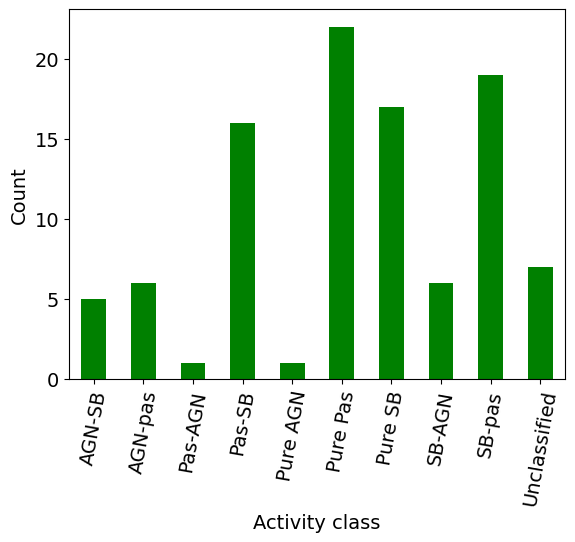

In [10]:
df_class.loc[:, 'classification'] = df_class['classification'].replace({0: 'Pure SB', 1: 'Pure AGN', 2: 'Pure Pas', 3: 'SB-AGN', 4: 'AGN-SB', 5: 'SB-pas', 6: 'Pas-SB', 7: 'Pas-AGN', 8: 'AGN-pas', -1: 'Unclassified'})
counts = df_class['classification'].value_counts().sort_index()
counts.plot(kind='bar', color='g', align='center')
plt.xlabel('Activity class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=80, fontsize=14)
plt.yticks(fontsize=14)
plt.show()
